## Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload

from tqdm import tqdm 

import sys
import csv
import string
import multiprocessing
import pandas as pd
import numpy as np

import keras
from keras.preprocessing import sequence
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D, Conv1D, GlobalMaxPooling1D, MaxPool1D
from keras.layers import Reshape, Flatten, Dropout, Concatenate, Dropout, Activation, Flatten
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.models import Sequential, load_model, Model
import tensorflow as tf

from nltk import word_tokenize
from nltk.corpus import stopwords

import gensim
from gensim.models import word2vec
from gensim.models.fasttext import FastText
from gensim.parsing.preprocessing import preprocess_string

Using TensorFlow backend.


## Defaults

In [2]:
train_data = 'data/train_news_data.csv'
valid_data = 'data/valid_news_data.csv'
test_data = 'data/test_news_data.csv'

cachedStopWords = stopwords.words("english")
cachedStopWords += list(string.punctuation)
cachedStopWords += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '-', '…', '’']

categories = ['bias', 'clickbait', 'conspiracy', 'fake', 'hate', 'junksci', 
              'political', 'reliable', 'rumor', 'satire', 'state', 'unreliable']

chunksize = 10000

In [3]:
train_size = 0
with open(train_data, 'r') as f:
    for line in tqdm(f):
        train_size += 1

6195861it [00:46, 132139.81it/s]


In [4]:
print("training size: {}".format(train_size))

training size: 6195861


In [5]:
valid_size = 0
with open(valid_data, 'r') as f:
    for line in tqdm(f):
        valid_size += 1

1548167it [00:11, 132662.84it/s]


In [6]:
print("validation size: {}".format(valid_size))

validation size: 1548167


## News Generator

In [7]:
def news_generator():
    with tqdm() as progress:
        for df in pd.read_csv(train_data, encoding='utf-8', engine='python', chunksize=chunksize):
            news_filter = df.category.isin(set(['fake', 'conspiracy', 'unreliable', 'reliable']))
            df_filtered = df[news_filter]
            
            for row in df_filtered.itertuples():
                label = 1 if row.category == 'reliable' else 0

                progress.update()
                yield '%s' % (row.content), label

## Show Content Length Distribution

In [ ]:
content_len = []
for i, (content, label) in enumerate(news_generator()):
    if i > 10 * 1000:
        break

    content_len.append(len(content))

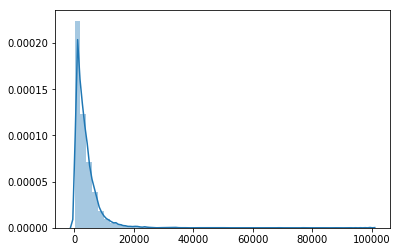

In [5]:
len(content_len), sum(content_len) / len(content_len), max(content_len), min(content_len)
sns.distplot(content_len)

## Generator

In [7]:
# cache GloVe 100d
f = open('data/glove.6B.100d.txt', 'r')

glove = {}
for line in f:
    values = line.split()
    
    word = values[0]
    glove[word] = np.asarray(values[1:], dtype='float32')
    
f.close()

In [8]:
max_words = 100

In [9]:
def _remove_stopwords(line):
    word_token = word_tokenize(line)
    words_stopped = [word for word in line if word not in cachedStopWords]
    return words_stopped

def _generator_process_line(line):
    words = _remove_stopwords(line[0])
    
    embedding = np.zeros((max_words, 100))
    
    for i, word in enumerate(words[:max_words]):
        if word in glove:
            embedding[i] = glove[word]
            
    return embedding, line[1]

def Generator(data, batch_size):
    while True:
        with open(data, 'r') as f:
            # skip header
            for _ in range(1):
                next(f)
                
            batch_i = 0
            batch_embedding = np.zeros((batch_size, max_words, 100))
            batch_label = np.zeros((batch_size, 1))
            
            reader = csv.reader(f)
            for line in reader:
                embedding, label = _generator_process_line(line)
                
                if (batch_i + 1) == batch_size:
                    yield batch_embedding, batch_label
                    
                    batch_embedding = np.zeros((batch_size, max_words, 100))
                    batch_label = np.zeros((batch_size, 1))
                    batch_i = 0
                else:
                    batch_embedding[batch_i] = embedding
                    batch_label[batch_i, 0] = label
                    batch_i += 1

## Keras Model

**Fake vs Reliable News Classification**

In [10]:
input_shape = max_words, 100

filters = 250
kernel_size = 3
hidden_dims = 250

batch_size = 64
epochs = 1

In [11]:
def cnn_model(input_shape, filters=250, kernel_size=3, hidden_dims=250):
    model = Sequential([
        Conv1D(filters, kernel_size, input_shape=(input_shape[0], input_shape[1]), 
               padding='valid',  activation='relu', strides=1),
        GlobalMaxPooling1D(),
        Dense(hidden_dims),
        Dropout(0.2),
        Activation('relu'),
        # We project onto a single unit output layer, and squash it with a sigmoid:
        Dense(1, activation='sigmoid')
    ])
        
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [12]:
model = cnn_model(input_shape, filters, kernel_size, hidden_dims)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 98, 250)           75250     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 251       
Total params: 138,251
Trainable params: 138,251
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit_generator(Generator(train_data, batch_size), steps_per_epoch=train_size//batch_size,
                    validation_data=Generator(valid_data, batch_size), validation_steps=valid_size//batch_size,
                    epochs=epochs, verbose=1)